# Atrial Fibrillation classification using Deep Learning

In [180]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wfdb # for reading signal files
import os
import neurokit2 as nk
import glob 
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

## The dataset

In [182]:
data_list = sorted(glob.glob('./../data/*.mat')) 
data_list = [os.path.splitext(x)[0] for x in data_list] # strips the .mat extensions from the list
label_list = pd.read_csv('./../data/REFERENCE.csv', header=None, names=['record num', 'diagnosis'])

'''
Function for generating single sample signals from wfdb file
'''
def sample_record(data, n):
    sample = data[n]
    record = wfdb.rdrecord(sample)
    return record.__dict__['p_signal'].flatten()

'''
Sample wfdb file
'''

print(wfdb.rdrecord('./../data/A00001').__dict__)

{'record_name': 'A00001', 'n_sig': 1, 'fs': 300, 'counter_freq': None, 'base_counter': None, 'sig_len': 9000, 'base_time': datetime.time(5, 5, 15), 'base_date': datetime.date(2000, 5, 1), 'comments': [], 'sig_name': ['ECG'], 'p_signal': array([[-0.127],
       [-0.162],
       [-0.197],
       ...,
       [-0.018],
       [-0.022],
       [-0.021]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['A00001.mat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [24], 'adc_gain': [1000.0], 'baseline': [0], 'units': ['mV'], 'adc_res': [16], 'adc_zero': [0], 'init_value': [-127], 'checksum': [0], 'block_size': [0]}


Each entry in the dataset contains, apart from the signal array, information such as sample rate (for the signals here is $300\:\rm{Hz}$). The dataset contains four distinct types of ECG recordings (shown below) - (a) normal sinus rhythm (N), (b) afib rhythm (A), (c) other/unclassified rhythm (O) and (d) noise (~). A normal sinus rhythm comprises of distiguishable of P- and T- waves and QRS complexes. Moreover, provided that the recording is being carried out in a steady environment, the time-lapse between successive QRS complexes is constant. The afib rhythm, on the otherhand, apart from unevenly spaced QRS complexes, also display a clear lack of P-waves.

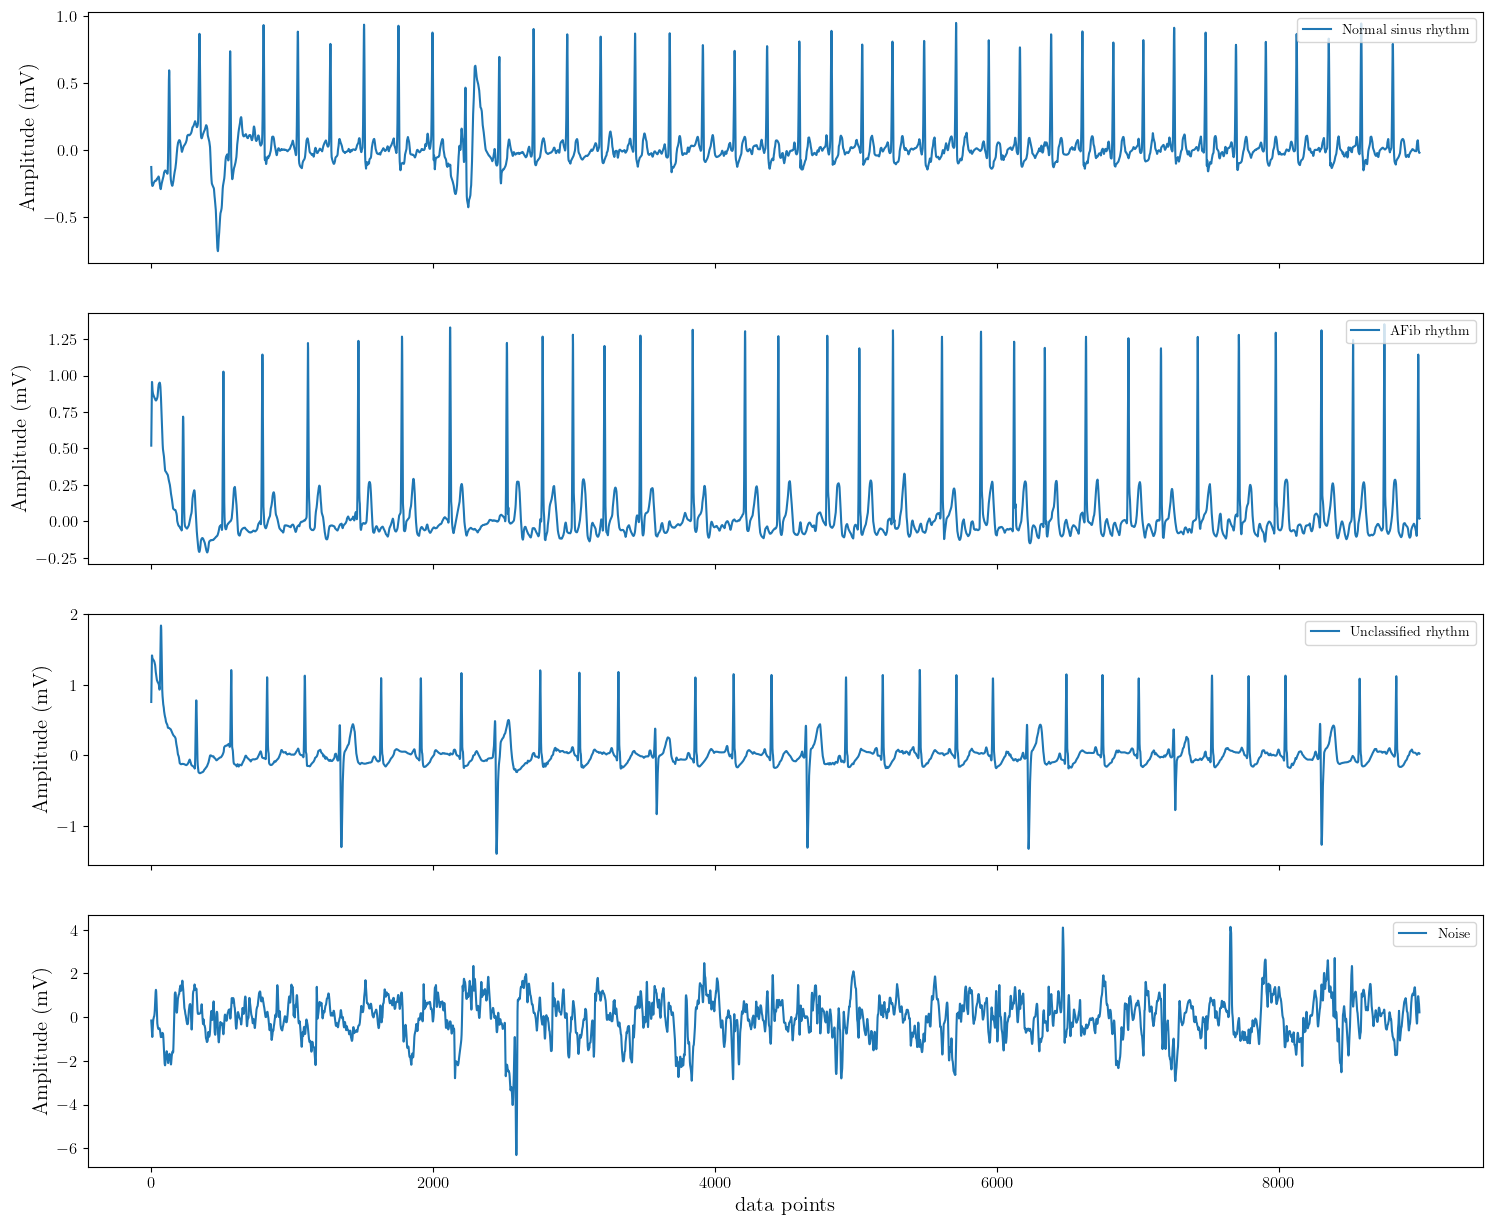

In [184]:
fig, ax = plt.subplots(4, 1, figsize=(18, 15), sharex=True)

ax[0].plot(sample_record(data_list, 0), label='Normal sinus rhythm')
ax[0].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[0].legend(loc='upper right')
ax[1].plot(sample_record(data_list, 3), label='AFib rhythm')
ax[1].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[1].legend(loc='upper right')
ax[2].plot(sample_record(data_list, 76), label='Unclassified rhythm')
ax[2].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[2].legend(loc='upper right')
ax[3].plot(sample_record(data_list, 1245), label='Noise')
ax[3].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[3].set_xlabel(r'data points', fontsize=15)
ax[3].legend(loc='upper right')

plt.show()

## Identifying features in signals

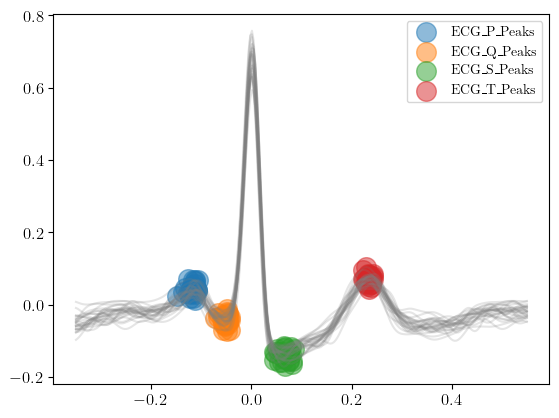

In [242]:
# truncated signals

ecg_sig1 = sample_record(data_list,0)[2500:]

processed_sig1_data = nk.ecg_process(
    ecg_sig1,
    sampling_rate=300,
    method='neurokit'
)

sig1_cleaned = processed_sig1_data[0]['ECG_Clean']
_, rpeaks1 = nk.ecg_peaks(sig1_cleaned, sampling_rate=300)
_, _ = nk.ecg_delineate(
    sig1_cleaned, 
    rpeaks1,
    sampling_rate=300,
    method='dwt',
    show=True,
    show_type='peaks'
)